#**Maestría en Inteligencia Artificial Aplicada**
## TC5035.10
##**Curso: Proyecto Integrador**
###Tecnológico de Monterrey

---

**Docente Titular**: Dra. Grettel Barceló Alonso y Dr. Luis Eduardo Falcón

**Docente Asistente**: Veronica Guzman del Valle

**Docente Tutor**: Eduviges Ludivina Facundo Flores

**Docente del ITCJ Responsable**: Mtra. Yadira Dozal Assmar

#**Nombre del Proyecto:**
---
*"Modelado de serie de tiempo para pronosticar la demanda de prórrogas de licenciatura en ITCJ"*

---

#**Integrantes Equipo #13:**
* A01796362 Eduardo Perez Carrillo
* A01795907 Nancy Teresa Zapien García
* A01796060 Hugo Alberto Cuevas García

#**Avance 1. ANALISIS EXPLORATORIO DE DATOS (EDA)**

In [1]:
# =========================
# LIBRERÍAS BASE
# =========================
import pandas as pd              # Manipulación y análisis de datos (DataFrames)
import numpy as np               # Operaciones numéricas (vectores, arrays, etc.)
import matplotlib.pyplot as plt  # Visualización (gráficas)


In [2]:
# =========================
# 1) CARGA DEL DATASET (CSV)
# =========================
# Ruta / nombre del archivo CSV exportado desde Excel.
# Nota: cuando se exporta desde Excel en ambientes Windows en español,
# suele guardarse con codificación Latin-1 (ISO-8859-1) o cp1252, no UTF-8.
path = "dataset.csv"

# Lectura del CSV:
# - encoding="latin1" evita errores de decodificación (UnicodeDecodeError) al contener acentos y caracteres especiales.
# - Si en otro equipo falla, alternativa típica: encoding="cp1252".
df = pd.read_csv(path, encoding="latin1")

In [3]:
# =========================
# 2) VALIDACIÓN RÁPIDA DE CARGA
# =========================
print("---------------------------")
# Shape: (filas, columnas). Sirve para verificar que coincida con el tamaño esperado del dataset.
print("Shape:", df.shape)

print("---------------------------")
# Vista rápida de las primeras filas: ayuda a confirmar estructura, valores y nombres de columnas.
display(df.head())

print("---------------------------")
# Tipos de datos detectados por pandas. Aquí es normal ver:
# - 'object' para texto y fechas cuando vienen como strings.
# Más adelante convertiremos las fechas a datetime.
print(df.dtypes)


---------------------------
Shape: (1765, 6)
---------------------------


,aprobado,carrera,periodo_solicitud,periodo_inicio,num_semestres_aprobados,semestre_actual
0,si,Licenciatura Administración,01/07/2019,01/01/2020,7,11
1,si,Ingeniería Industria EAD,01/07/2019,01/01/2020,4,12
2,si,Ingeniería Industrial,01/07/2019,01/01/2020,13,6
3,si,Licenciatura Administración,01/07/2019,01/01/2020,11,7
4,si,Licenciatura Administración,01/07/2019,01/01/2020,8,8


---------------------------
aprobado                   object
carrera                    object
periodo_solicitud          object
periodo_inicio             object
num_semestres_aprobados     int64
semestre_actual             int64
dtype: object


## **ANÁLISIS DE DATOS FALTANTES (EDA)**

En este bloque se revisa la calidad del dataset,
identificando valores faltantes (NaN) por columna.

Este paso es fundamental antes de cualquier transformación o modelado, ya que valores faltantes pueden sesgar resultados.

In [4]:
missing_summary = (
    df.isna()
      .sum()
      .to_frame(name="n_missing")
      .assign(pct_missing=lambda x: 100 * x["n_missing"] / len(df))
)

display(missing_summary)

,n_missing,pct_missing
aprobado,0,0.0
carrera,0,0.0
periodo_solicitud,0,0.0
periodo_inicio,0,0.0
num_semestres_aprobados,0,0.0
semestre_actual,0,0.0


Se revisa la presencia de valores faltantes en las columnas críticas del análisis. Este paso se realiza después de normalizar los nombres de las columnas.

In [5]:
print("Columnas disponibles en el dataset:")
print(df.columns.tolist())

# Columnas críticas esperadas
expected_critical_cols = [
    "Aprobado",
    "carrera",
    "periodo_solicitud",
    "periodo_inicio"
]

# Mantener solo las columnas que realmente existen
critical_cols = [c for c in expected_critical_cols if c in df.columns]

print("\nColumnas críticas encontradas:")
print(critical_cols)

# Revisión de valores nulos
missing_critical = (
    df[critical_cols]
    .isna()
    .sum()
    .to_frame(name="n_missing")
)

display(missing_critical)

Columnas disponibles en el dataset:
['aprobado', 'carrera', 'periodo_solicitud', 'periodo_inicio', 'num_semestres_aprobados', 'semestre_actual']

Columnas críticas encontradas:
['carrera', 'periodo_solicitud', 'periodo_inicio']


,n_missing
carrera,0
periodo_solicitud,0
periodo_inicio,0


In [6]:
# Revisión de strings vacíos o solo espacios
empty_strings = (
    df[critical_cols]
    .astype(str)
    .apply(lambda col: col.str.strip().eq("").sum())
)

empty_strings


,0
carrera,0
periodo_solicitud,0
periodo_inicio,0



## **NORMALIZACIÓN DE NOMBRES DE COLUMNAS**


Estandarizamos los nombres de las columnas:
 - strip(): elimina espacios en blanco al inicio y final
 - lower(): convierte todo a minúsculas

Esto es una buena práctica porque:
 1) Evita errores por diferencias de mayúsculas/minúsculas.
 2) Facilita la escritura de código reproducible.
 3) Permite mantener consistencia en todo el pipeline.

In [7]:
df.columns = [c.strip().lower() for c in df.columns]

# Imprimimos la lista de columnas para verificar el resultado
print(df.columns.tolist())


['aprobado', 'carrera', 'periodo_solicitud', 'periodo_inicio', 'num_semestres_aprobados', 'semestre_actual']



## **NORMALIZACIÓN DE LA VARIABLE OBJETIVO (APROBADO)**

El objetivo es convertir la variable categórica "aprobado"

en una variable binaria numérica:

   1 -> solicitud aprobada
   
   0 -> solicitud no aprobada

Esto es necesario porque:
 - Los modelos de machine learning y series temporales
   trabajan con variables numéricas.
 - Facilita conteos, agregaciones y métricas.
 - Evita ambigüedades por diferentes formas de escritura.

In [8]:
df["aprobado_norm"] = (
    df["aprobado"]
    # Convertimos a string para evitar problemas si hay valores nulos o mixtos
    .astype(str)
    # Eliminamos espacios en blanco
    .str.strip()
    # Convertimos a minúsculas para estandarizar
    .str.lower()
    # Normalizamos variaciones comunes del "sí"
    .replace({"sí": "si"})
    # Mapeo final a binario:
    # valores considerados como aprobación -> 1
    # cualquier otro valor -> 0
    .map(lambda x: 1 if x in ["si", "1", "true", "aprobado", "yes", "y"] else 0)
)

# =========================
# VERIFICACIÓN DE RESULTADOS
# =========================
# Distribución original de la variable categórica
print("Valores originales:")
print(df["aprobado"].value_counts())

# Distribución de la variable binaria normalizada
print("\nValores normalizados:")
print(df["aprobado_norm"].value_counts())


Valores originales:
aprobado
Si    1136
si     484
No     112
no      33
Name: count, dtype: int64

Valores normalizados:
aprobado_norm
1    1620
0     145
Name: count, dtype: int64



## **EXPLORACIÓN DE LA VARIABLE "CARRERA"**

En esta etapa realizamos una exploración básica de la variable categórica "carrera"

 con el objetivo de:
  1) Conocer cuántas carreras distintas existen en el dataset.
 2) Identificar las carreras con mayor número de solicitudes.
 3) Detectar posibles categorías dominantes o poco representadas.


In [9]:
# Número total de carreras únicas
print("Número de carreras únicas:", df["carrera"].nunique())

# Frecuencia de solicitudes por carrera
# Se muestran solo las 15 carreras con mayor número de registros
df["carrera"].value_counts().head(15)

Número de carreras únicas: 15


,count
carrera,
Ingeniería Industrial,325
Licenciatura Administración,321
Contador Público,207
Ingeniería Mecatrónica,181
Ingeniería Logística,173
Ingeniería Gestión Empresarial,161
Ingeniería Sistemas Computacionales,140
Ingeniería Electromecanica,86
Ingeniería Mecánica,41



## **NORMALIZACIÓN Y AGRUPACIÓN DE LA VARIABLE "CARRERA"**

En este paso se crea una versión normalizada de la variable "carrera" con el objetivo de reducir la cardinalidad de categorías y facilitar el análisis agregado.

Específicamente, todas las carreras que pertenecen a la modalidad de Educación a Distancia (EAD) se agrupan en una sola categoría: "EAD".


In [10]:
# Crear una copia normalizada de la carrera:
# - astype(str): asegura compatibilidad aunque existan valores nulos
# - strip(): elimina espacios en blanco al inicio y final
df["carrera_norm"] = df["carrera"].astype(str).str.strip()

# Agrupar todas las carreras cuya descripción termina en "EAD"
# - str.upper(): evita problemas por mayúsculas/minúsculas
# - str.endswith("EAD"): identifica la modalidad EAD
#
# Todas estas observaciones se asignan a la categoría única "EAD"
df.loc[
    df["carrera_norm"].str.upper().str.endswith("EAD"),
    "carrera_norm"
] = "EAD"

# =========================
# VERIFICACIÓN DE RESULTADOS
# =========================
# Distribución original de carreras (top 15)
print("Carreras originales (top 15):")
print(df["carrera"].value_counts().head(15))

# Distribución después de la normalización (top 15)
print("\nCarreras normalizadas (top 15):")
print(df["carrera_norm"].value_counts().head(15))



Carreras originales (top 15):
carrera
Ingeniería Industrial                                        325
Licenciatura Administración                                  321
Contador Público                                             207
Ingeniería Mecatrónica                                       181
Ingeniería Logística                                         173
Ingeniería Gestión Empresarial                               161
Ingeniería Sistemas Computacionales                          140
Ingeniería Electromecanica                                    86
Ingeniería Mecánica                                           41
Ingeniería Eléctrica                                          38
Ingeniería Industria EAD                                      33
Ingeniería Electrónica                                        25
Ingeniería Tecnologías de la Información y Comunicaciones     22
Ingeniería Gestión Empresarial EAD                            10
Ingeniería Sistemas Computacionales EAD             

In [11]:
def parse_and_fix_semester_dates(s: pd.Series) -> pd.Series:
    """
    Convierte una serie de fechas a formato datetime semestral.

    La función:
    - Maneja ambigüedad entre formatos dd/mm/yyyy y mm/dd/yyyy.
    - Identifica automáticamente el parseo más coherente.
    - Colapsa todas las fechas a un esquema semestral:
        * Enero (S1)
        * Julio (S2)

    Parámetros
    ----------
    s : pd.Series
        Serie de fechas en formato texto.

    Retorna
    -------
    pd.Series
        Serie de fechas normalizadas a formato datetime,
        usando únicamente enero o julio como meses válidos.
    """

    # =========================
    # 1) PARSEO DE FECHAS CON AMBIGÜEDAD
    # =========================
    # Intento 1: interpretar la fecha como día/mes/año (formato común en LATAM)
    dt1 = pd.to_datetime(s, errors="coerce", dayfirst=True)

    # Intento 2: interpretar la fecha como mes/día/año (formato común en sistemas anglosajones)
    dt2 = pd.to_datetime(s, errors="coerce", dayfirst=False)

    # =========================
    # 2) SELECCIÓN DEL PARSEO MÁS COHERENTE
    # =========================
    # Extraemos los meses resultantes de cada intento
    m1 = dt1.dt.month
    m2 = dt2.dt.month

    # Regla de decisión:
    # - Si el primer intento (dt1) NO cae en un mes semestral válido (enero o julio)
    # - PERO el segundo intento (dt2) SÍ cae en enero o julio
    # entonces asumimos que el formato correcto era mm/dd/yyyy
    use_dt2 = (~m1.isin([1, 7])) & (m2.isin([1, 7]))

    # Inicialmente usamos el primer parseo
    dt = dt1.copy()

    # Sustituimos por el segundo parseo solo donde sea más consistente
    dt[use_dt2] = dt2[use_dt2]

    # =========================
    # 3) COLAPSO A FECHAS SEMESTRALES
    # =========================
    # Regla semestral:
    # - Mes <= 6  -> Primer semestre (enero)
    # - Mes > 6   -> Segundo semestre (julio)
    fixed_month = np.where(dt.dt.month <= 6, 1, 7)

    # Construimos una nueva fecha usando:
    # - Año original
    # - Mes semestral (1 o 7)
    # - Día fijo = 1
    dt_fixed = pd.to_datetime(
        dict(year=dt.dt.year, month=fixed_month, day=1),
        errors="coerce"
    )

    return dt_fixed



## **PARSEO Y NORMALIZACIÓN DE FECHAS A FORMATO SEMESTRAL**

 Aplicamos la función parse_and_fix_semester_dates() a las dos columnas temporales clave:
 - periodo_solicitud: semestre en el que el alumno realizó formalmente la solicitud.
 - periodo_inicio: semestre en el que el alumno desea comenzar a utilizar la prórroga.

 Ambas se convierten a datetime y se colapsan a una fecha representativa semestral:
 - 01/01/YYYY  ->  YYYY-S1
 - 01/07/YYYY  ->  YYYY-S2

In [12]:
# Esto estandariza el eje temporal para agregaciones y modelado de series.

df["periodo_solicitud_dt"] = parse_and_fix_semester_dates(df["periodo_solicitud"])
df["periodo_inicio_dt"] = parse_and_fix_semester_dates(df["periodo_inicio"])

# =========================
# CONTROL DE CALIDAD: VALORES NULOS
# =========================
# Verificamos cuántas fechas no pudieron ser parseadas (NaT).
# Un número alto aquí indicaría:
# - formatos inválidos,
# - valores faltantes,
# - errores de captura,
# - o inconsistencias que requieren limpieza adicional.
print("Nulos en periodo_solicitud_dt:", df["periodo_solicitud_dt"].isna().sum())
print("Nulos en periodo_inicio_dt:", df["periodo_inicio_dt"].isna().sum())



Nulos en periodo_solicitud_dt: 0
Nulos en periodo_inicio_dt: 0



## **VALIDACIÓN DE CONSISTENCIA SEMESTRAL**

En este paso verificamos explícitamente que las fechas normalizadas
 cumplen con el esquema semestral definido:
   - Enero (mes = 1)  -> Primer semestre (S1)
   - Julio  (mes = 7) -> Segundo semestre (S2)

 No deberían aparecer otros meses (2–6, 8–12).
 Si aparecen, indicaría un error en el parseo o en los datos originales.


In [13]:
print(
    "Meses únicos en periodo_solicitud_dt:",
    sorted(df["periodo_solicitud_dt"].dt.month.unique())
)

print(
    "Meses únicos en periodo_inicio_dt:",
    sorted(df["periodo_inicio_dt"].dt.month.unique())
)

Meses únicos en periodo_solicitud_dt: [np.int32(1), np.int32(7)]
Meses únicos en periodo_inicio_dt: [np.int32(1), np.int32(7)]



## **CREACIÓN DE ETIQUETAS SEMESTRALES (YYYY-S1 / YYYY-S2)**

En este paso construimos etiquetas de semestre en formato:
   "AÑO-S1" para enero (1)
   "AÑO-S2" para julio (7)

Estas etiquetas son útiles para:
 - visualización y análisis exploratorio (EDA)
 - reportes y tablas (más legible que un datetime)
 - validación rápida del alineamiento temporal

Importante: para modelado, seguimos usando datetime/índices numéricos, pero esta columna mejora la interpretabilidad.

In [14]:
def semestre_label(dt):
    """
    Convierte una serie datetime semestral (enero/julio) a una etiqueta tipo 'YYYY-S1' o 'YYYY-S2'.

    Parámetros
    ----------
    dt : pd.Series (datetime64)
        Serie de fechas ya normalizadas a meses 1 (enero) o 7 (julio).

    Retorna
    -------
    pd.Series
        Etiquetas en texto: 'YYYY-S1' / 'YYYY-S2'.
    """
    # Mapear el mes a semestre:
    # - 1 -> S1
    # - 7 -> S2
    semestre = dt.dt.month.map({1: "S1", 7: "S2"})

    # Concatenar año + '-' + semestre
    return dt.dt.year.astype(str) + "-" + semestre


# Crear etiquetas para:
# - Semestre en el que se solicitó formalmente la prórroga
df["semestre_solicitud"] = semestre_label(df["periodo_solicitud_dt"])

# - Semestre en el que se planea utilizar la prórroga
df["semestre_inicio"] = semestre_label(df["periodo_inicio_dt"])


# =========================
# VERIFICACIÓN VISUAL (SANITY CHECK)
# =========================
# Mostramos un subconjunto de columnas para confirmar:
# 1) que las fechas se parsearon correctamente,
# 2) que la etiqueta coincide con el semestre real (enero/julio),
# 3) que no hay desalineaciones evidentes entre texto original y datetime.
df[[
    "periodo_solicitud", "periodo_solicitud_dt", "semestre_solicitud",
    "periodo_inicio", "periodo_inicio_dt", "semestre_inicio"
]].head(10)


,periodo_solicitud,periodo_solicitud_dt,semestre_solicitud,periodo_inicio,periodo_inicio_dt,semestre_inicio
0,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
1,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
2,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
3,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
4,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
5,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
6,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
7,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
8,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
9,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1



## **ORDENAMIENTO TEMPORAL POR SEMESTRE DE SOLICITUD**

Para cualquier análisis de series temporales es indispensable que los datos estén correctamente ordenados en el tiempo.

Aquí ordenamos el dataset usando la fecha datetime semestral asociada al periodo de solicitud de la prórroga.

In [15]:

df = (
    df
    .sort_values("periodo_solicitud_dt")  # orden cronológico
    .reset_index(drop=True)               # reinicio de índice para coherencia
)

# =========================
# VERIFICACIÓN DEL RANGO TEMPORAL
# =========================
# Confirmamos explícitamente cuál es:
# - el primer semestre presente en el dataset
# - el último semestre presente en el dataset
#
# Esta información será clave más adelante para:
# - definir puntos de corte (cutoff) configurables,
# - validar horizontes de pronóstico,
# - justificar el rango temporal analizado.

print("Primer semestre:", df["semestre_solicitud"].iloc[0])
print("Último semestre:", df["semestre_solicitud"].iloc[-1])


Primer semestre: 2019-S2
Último semestre: 2025-S2


In [18]:
# =========================
# PARÁMETRO CONFIGURABLE
# =========================
ULTIMO_SEMESTRE = "2025-S2"   # <-- cambia aquí cuando lo necesites



## **CONVERSIÓN DE SEMESTRE A ÍNDICE TEMPORAL NUMÉRICO**

En series temporales es común trabajar con un índice numérico ordenable
(0, 1, 2, 3, ...) en lugar de etiquetas textuales.

 Aquí convertimos etiquetas del tipo:

   "YYYY-S1"
   "YYYY-S2"

 a un índice entero continuo que respeta el orden temporal.

La regla utilizada es:
  índice = (año * 2) + offset

 donde:
   offset = 0  -> primer semestre (S1)
   offset = 1  -> segundo semestre (S2)

 Ejemplos:
   2023-S1 -> 2023*2 + 0 = 4046
   2023-S2 -> 2023*2 + 1 = 4047
   2024-S1 -> 2024*2 + 0 = 4048

 Este índice:
 - preserva el orden cronológico,
 - permite comparar semestres con operadores numéricos (<, >, <=),
 - facilita la creación de puntos de corte (cutoff),
 - es ideal para validación walk-forward.


In [19]:

def semestre_index(label):
    """
    Convierte una etiqueta semestral 'YYYY-S1' / 'YYYY-S2'
    en un índice temporal entero ordenable.

    Parámetros
    ----------
    label : str
        Etiqueta semestral en formato 'YYYY-S1' o 'YYYY-S2'.

    Retorna
    -------
    int
        Índice temporal numérico que preserva el orden cronológico.
    """
    # Separar la etiqueta en año y semestre
    year, sem = label.split("-")

    # Asignar offset según semestre:
    # S1 -> 0
    # S2 -> 1
    offset = 0 if sem == "S1" else 1

    # Construir el índice final
    return int(year) * 2 + offset


# =========================
# APLICACIÓN DEL ÍNDICE AL DATASET
# =========================
# Creamos una nueva columna con el índice semestral numérico
# que será usada para:
# - filtrar rangos temporales,
# - definir el último semestre considerado (cutoff),
# - validar el orden temporal del dataset.
df["semestre_idx"] = df["semestre_solicitud"].apply(semestre_index)


# =========================
# DEFINICIÓN DEL PUNTO DE CORTE (CUTOFF)
# =========================
# Convertimos el último semestre permitido (configurable)
# al mismo índice numérico para poder compararlo directamente.
#
# Ejemplo:
#   ULTIMO_SEMESTRE = "2025-S2"
#   cutoff_idx = 2025*2 + 1 = 4051
cutoff_idx = semestre_index(ULTIMO_SEMESTRE)

print("Cutoff index:", cutoff_idx)

Cutoff index: 4051



## **APLICACIÓN DEL CUTOFF TEMPORAL (FILTRADO DEL DATASET)**

En este paso se construye el dataset que será utilizado para:
 - análisis exploratorio (EDA),
 - agregaciones temporales,
 - entrenamiento de modelos,
 - validación walk-forward.

Para ello, se aplica un punto de corte temporal (cutoff_idx) que define el último semestre permitido en el análisis.

 Cualquier observación con semestre_idx > cutoff_idx se excluye, garantizando que NO se utilice información futura (data leakage).

In [20]:
df_eda = (
    df[df["semestre_idx"] <= cutoff_idx]
    .copy()   # Se crea una copia explícita para evitar SettingWithCopyWarning
)

# =========================
# VERIFICACIÓN DEL RANGO TEMPORAL INCLUIDO
# =========================
# Mostramos explícitamente qué semestres quedaron dentro del rango analizado.
# Esta salida sirve para:
# - confirmar que el cutoff se aplicó correctamente,
# - documentar el periodo histórico utilizado,
# - detectar exclusiones inesperadas.
print("Semestres incluidos:")
print(sorted(df_eda["semestre_solicitud"].unique()))


Semestres incluidos:
['2019-S2', '2020-S2', '2021-S1', '2021-S2', '2022-S1', '2022-S2', '2023-S1', '2023-S2', '2024-S1', '2024-S2', '2025-S1', '2025-S2']



## **AGREGACIÓN TEMPORAL POR SEMESTRE**

 En este paso se construye la serie temporal agregada a nivel semestral.

 Cada fila del resultado representa un semestre académico (enero o julio),
 y las métricas agregadas describen la demanda y el resultado de las solicitudes
 realizadas en dicho semestre.

Importante:
 - La agregación se hace sobre "periodo_solicitud_dt", es decir,
   el semestre en el que el alumno solicitó formalmente la prórroga.
 - No se utiliza el semestre de inicio, ya que el objetivo es modelar la demanda de solicitudes, no su ejecución futura.

In [21]:

agg = (
    df_eda
    # Agrupamos por semestre (fecha datetime normalizada a enero/julio)
    .groupby("periodo_solicitud_dt")
    .agg(
        # Número total de solicitudes en el semestre:
        # - "size" cuenta todas las filas del grupo
        total_solicitudes=("aprobado_norm", "size"),

        # Número de solicitudes aprobadas:
        # - como aprobado_norm es binaria (0/1),
        #   la suma equivale al total de aprobaciones
        aprobadas=("aprobado_norm", "sum"),
    )
    # Ordenamos cronológicamente por semestre
    .sort_index()
)

# =========================
# MÉTRICAS DERIVADAS
# =========================
# A partir de las métricas básicas calculamos indicadores adicionales
# que permiten un análisis más completo del comportamiento institucional.

# Solicitudes no aprobadas por semestre
agg["no_aprobadas"] = agg["total_solicitudes"] - agg["aprobadas"]

# Tasa de aprobación:
# proporción de solicitudes aprobadas respecto al total del semestre
agg["tasa_aprobacion"] = agg["aprobadas"] / agg["total_solicitudes"]

# Visualización del DataFrame resultante
display(agg)


,total_solicitudes,aprobadas,no_aprobadas,tasa_aprobacion
periodo_solicitud_dt,,,,
2019-07-01,39,39,0,1.000000
2020-07-01,175,160,15,0.914286
2021-01-01,254,251,3,0.988189
2021-07-01,49,34,15,0.693878
2022-01-01,30,17,13,0.566667
2022-07-01,212,196,16,0.924528
2023-01-01,121,95,26,0.785124
2023-07-01,258,255,3,0.988372
2024-01-01,128,109,19,0.851562



## **VISUALIZACIÓN EXPLORATORIA: DEMANDA TOTAL POR SEMESTRE**

 En esta gráfica se visualiza la evolución temporal del número total
 de solicitudes de prórroga por semestre.

 El objetivo de esta visualización es:
 - identificar tendencias generales (crecimiento, estabilidad, descenso),
 - detectar picos o caídas abruptas,
 - evaluar la variabilidad semestral,
 - validar que la serie tenga sentido antes de aplicar modelos predictivos.

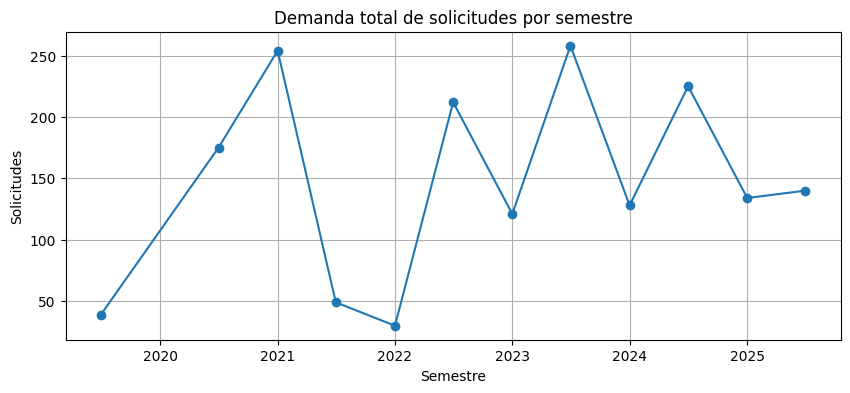

In [22]:

plt.figure(figsize=(10,4))  # Tamaño de la figura (ancho, alto)

# Gráfica de línea:
# - eje X: semestres (índice datetime semestral)
# - eje Y: número total de solicitudes
# - marker="o": facilita identificar cada observación semestral
plt.plot(
    agg.index,
    agg["total_solicitudes"],
    marker="o"
)

# Título y etiquetas
plt.title("Demanda total de solicitudes por semestre")
plt.xlabel("Semestre")
plt.ylabel("Solicitudes")

# Cuadrícula para facilitar lectura de valores y tendencias
plt.grid(True)

# Renderizar la gráfica
plt.show()




## **VISUALIZACIÓN EXPLORATORIA: SOLICITUDES APROBADAS POR SEMESTRE**

 Esta gráfica muestra la evolución temporal del número de solicitudes
 de prórroga que fueron aprobadas en cada semestre.

 Su propósito es:
 - analizar la dinámica de las aprobaciones a lo largo del tiempo,
 - comparar visualmente contra la demanda total,
 - evaluar la estabilidad de la política institucional de aprobación,
 - detectar posibles cambios estructurales.

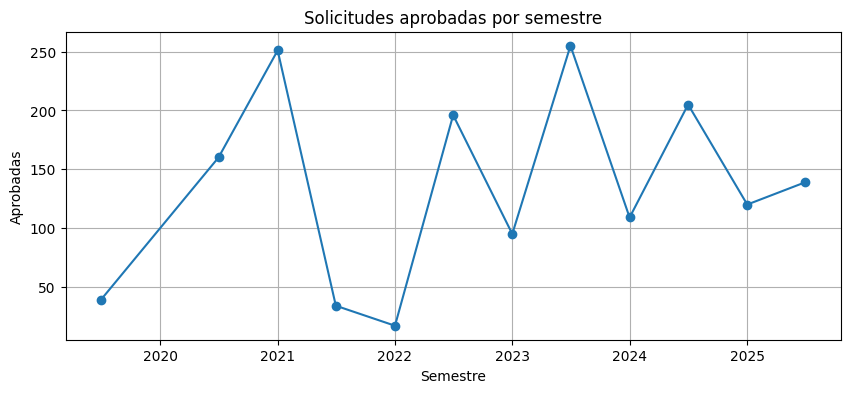

In [23]:
plt.figure(figsize=(10,4))  # Tamaño de la figura

# Gráfica de línea de las solicitudes aprobadas por semestre
plt.plot(
    agg.index,
    agg["aprobadas"],
    marker="o"
)

# Título y etiquetas
plt.title("Solicitudes aprobadas por semestre")
plt.xlabel("Semestre")
plt.ylabel("Aprobadas")

# Cuadrícula para facilitar la lectura
plt.grid(True)

# Mostrar la gráfica
plt.show()



## **VISUALIZACIÓN EXPLORATORIA: TASA DE APROBACIÓN POR SEMESTRE**

 En esta gráfica se muestra la tasa de aprobación de solicitudes de prórroga por semestre, definida como:

       tasa_aprobacion = solicitudes_aprobadas / total_solicitudes

 Este indicador es clave porque:
 - permite evaluar la estabilidad de la política institucional,
 - normaliza la información respecto al volumen de solicitudes,
 - facilita comparaciones entre periodos con distinta demanda.

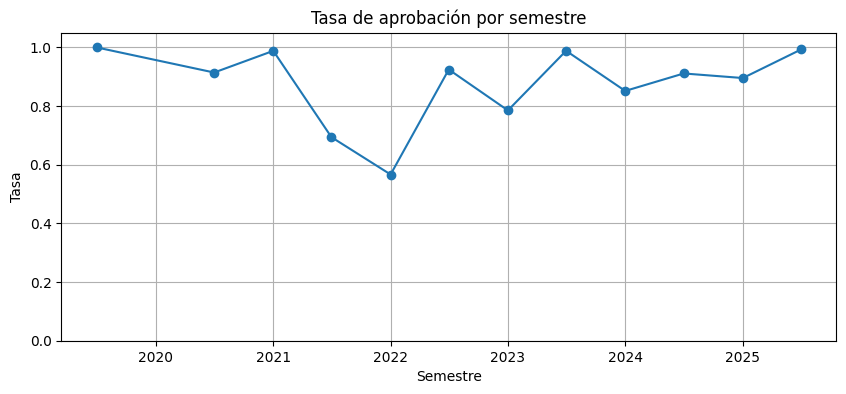

In [24]:

plt.figure(figsize=(10,4))  # Tamaño de la figura

# Gráfica de línea de la tasa de aprobación
plt.plot(
    agg.index,
    agg["tasa_aprobacion"],
    marker="o"
)

# Fijamos límites del eje Y entre 0 y 1
# (con un pequeño margen superior para evitar recortes visuales)
plt.ylim(0, 1.05)

# Título y etiquetas
plt.title("Tasa de aprobación por semestre")
plt.xlabel("Semestre")
plt.ylabel("Tasa")

# Cuadrícula para facilitar la lectura y comparación entre periodos
plt.grid(True)

# Mostrar la gráfica
plt.show()



## **ANÁLISIS DE ESTACIONALIDAD BÁSICA: COMPARACIÓN S1 VS S2**

 En este paso se evalúa si existe un comportamiento sistemáticamente distinto
 entre el primer semestre (S1) y el segundo semestre (S2).

 La estacionalidad semestral es relevante porque:
 - puede justificar el uso de modelos con componente estacional (p. ej. Holt-Winters),
 - ayuda a interpretar picos recurrentes,
 - permite entender diferencias operativas entre periodos académicos.

In [25]:
# Extraemos el semestre (S1 / S2) a partir del mes del índice datetime:
# - mes = 1  -> S1
# - mes = 7  -> S2
agg["semestre"] = agg.index.month.map({1: "S1", 7: "S2"})

# =========================
# COMPARACIÓN PROMEDIO POR SEMESTRE
# =========================
# Calculamos el promedio semestral de:
# - total de solicitudes
# - solicitudes aprobadas
#
# Al usar la media:
# - suavizamos la variabilidad interanual,
# - destacamos diferencias estructurales entre S1 y S2.
display(
    agg
    .groupby("semestre")[["total_solicitudes", "aprobadas"]]
    .mean()
)

,total_solicitudes,aprobadas
semestre,,
S1,133.400000,118.400000
S2,156.857143,146.857143



## **ANÁLISIS DE DEMANDA POR MODALIDAD (EAD vs NO EAD)**

 En este bloque se analiza la evolución semestral de las solicitudes

 separando dos grandes modalidades:
   - Educación a Distancia (EAD)
   - Modalidad presencial (No EAD)

 El objetivo es:
 - identificar si la modalidad EAD presenta un crecimiento diferenciado,
 - comparar dinámicas temporales entre modalidades,
 - detectar posibles cambios estructurales en la demanda.

In [26]:

agg_ead = (
    df_eda
    # Creamos una variable binaria que indica si la solicitud pertenece a EAD:
    # - 1 -> carrera EAD
    # - 0 -> carrera No EAD
    #
    # Se utiliza astype(int) para facilitar agregaciones posteriores.
    .assign(es_ead=df_eda["carrera_norm"].eq("EAD").astype(int))

    # Agrupamos por:
    # - semestre de solicitud
    # - modalidad (EAD / No EAD)
    .groupby(["periodo_solicitud_dt", "es_ead"])

    # Contamos el número de solicitudes por grupo
    .size()

    # Convertimos la variable es_ead en columnas:
    # - una columna para EAD
    # - una columna para No EAD
    #
    # fill_value=0 asegura que, si en un semestre no hay solicitudes
    # de alguna modalidad, se registre como 0 y no como NaN.
    .unstack(fill_value=0)

    # Ordenamos cronológicamente por semestre
    .sort_index()
)

# Renombramos las columnas para mayor claridad en visualizaciones y tablas
agg_ead.columns = ["No EAD", "EAD"]

# Visualizamos la tabla resultante
display(agg_ead)



,No EAD,EAD
periodo_solicitud_dt,,
2019-07-01,34,5
2020-07-01,171,4
2021-01-01,248,6
2021-07-01,48,1
2022-01-01,29,1
2022-07-01,212,0
2023-01-01,121,0
2023-07-01,258,0
2024-01-01,128,0


In [27]:
# =========================
# PARÁMETROS CONFIGURABLES
# =========================
ULTIMO_ANIO = 2025   # último año incluido en el análisis


## **AGREGACIÓN ANUAL: DEMANDA TOTAL Y APROBADAS POR AÑO**

 En esta sección transformamos la serie semestral (enero/julio) a una serie anual.
 El objetivo es analizar y modelar la demanda a un nivel temporal más agregado:
 - Menos ruido (al sumar ambos semestres dentro del año)
 - Menor granularidad (menos puntos en el tiempo)

 Este enfoque es útil cuando:
 - queremos una visión de tendencia macro,
 - el número de observaciones semestrales es bajo y deseamos estabilizar la serie,
 - buscamos pronósticos anuales (+2 o +3 años, por ejemplo).

 NOTA:
 - "periodo_solicitud_dt" ya fue normalizado para caer en 1 de enero o 1 de julio.
 - Al extraer el año (.dt.year) estamos agrupando ambos semestres dentro del mismo año.


,total_solicitudes,aprobadas,no_aprobadas,tasa_aprobacion
anio_solicitud,,,,
2019,39,39,0,1.000000
2020,175,160,15,0.914286
2021,303,285,18,0.940594
2022,242,213,29,0.880165
2023,379,350,29,0.923483
2024,353,314,39,0.889518
2025,274,259,15,0.945255


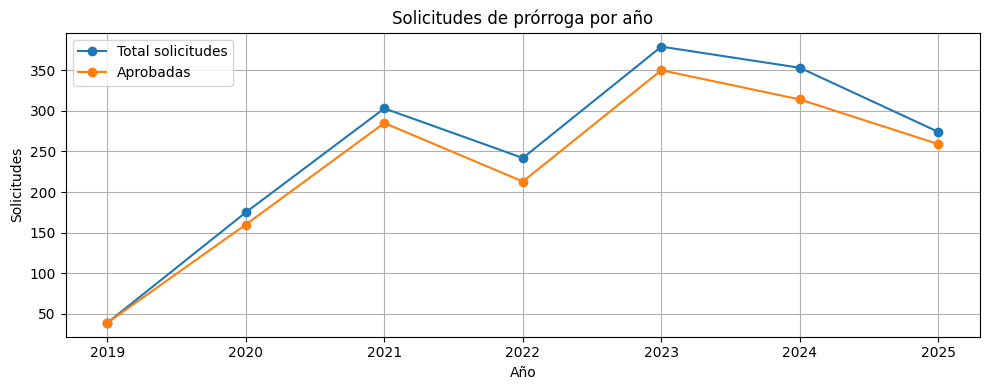

In [28]:

# =========================
# 1) CREAR VARIABLE "AÑO"
# =========================
# Se extrae el año del periodo de solicitud.
# Ejemplo: 2024-01-01 y 2024-07-01 -> anio_solicitud = 2024
df_eda["anio_solicitud"] = df_eda["periodo_solicitud_dt"].dt.year

# Verificación rápida: confirmar que el año corresponde correctamente a la fecha
df_eda[["periodo_solicitud_dt", "anio_solicitud"]].head()

# =========================
# 2) AGREGACIÓN ANUAL
# =========================
# Agrupamos por anio_solicitud y calculamos:
# - total_solicitudes: número de registros (size)
# - aprobadas: suma de aprobado_norm (porque aprobado_norm es 0/1)
#
# Esto produce una serie anual con índice = año.
agg_anual = (
    df_eda
    .groupby("anio_solicitud")
    .agg(
        total_solicitudes=("aprobado_norm", "size"),
        aprobadas=("aprobado_norm", "sum")
    )
    .sort_index()
)

# =========================
# 3) CORTE CONFIGURABLE HASTA ULTIMO_ANIO
# =========================
# Igual que en el caso semestral, dejamos el último año como variable
# para que el análisis sea reproducible y configurable (por ejemplo, si después
# agregas datos de un año adicional).
#
# IMPORTANTE:
# - ULTIMO_ANIO debe estar definido previamente (ej. 2025).
# - Este corte evita que análisis/forecast se mezclen con periodos que quieras reservar.
agg_anual_cut = agg_anual[agg_anual.index <= ULTIMO_ANIO].copy()

# =========================
# 4) VARIABLES DERIVADAS (NO APROBADAS Y TASA)
# =========================
# no_aprobadas = total - aprobadas
# tasa_aprobacion = aprobadas / total
#

agg_anual_cut["no_aprobadas"] = (
    agg_anual_cut["total_solicitudes"] - agg_anual_cut["aprobadas"]
)

# Tasa de aprobación anual (proporción)
agg_anual_cut["tasa_aprobacion"] = (
    agg_anual_cut["aprobadas"] / agg_anual_cut["total_solicitudes"]
)

# Visualización de la tabla anual
display(agg_anual_cut)

# ============================================================
# VISUALIZACIÓN: SOLICITUDES POR AÑO (TOTAL VS APROBADAS)
# ============================================================
# Esta gráfica permite observar:
# - tendencia de largo plazo (crecimiento/disminución anual),
# - relación entre demanda total y aprobaciones,
# - diferencias entre años (posibles cambios institucionales o de demanda).
#
# Al usar datos anuales:
# - la señal suele ser más estable (menos variación semestral),
# - pero también hay menos puntos para entrenar modelos.

plt.figure(figsize=(10,4))

# Total solicitudes por año
plt.plot(
    agg_anual_cut.index,
    agg_anual_cut["total_solicitudes"],
    marker="o",
    label="Total solicitudes"
)

# Aprobadas por año
plt.plot(
    agg_anual_cut.index,
    agg_anual_cut["aprobadas"],
    marker="o",
    label="Aprobadas"
)

plt.title("Solicitudes de prórroga por año")
plt.xlabel("Año")
plt.ylabel("Solicitudes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **CONSTRUCCIÓN DE LA SERIE TEMPORAL ANUAL (FORMATO MODELABLE)**

 En este bloque se transforma la tabla agregada anual (agg_anual_cut)
 en una estructura explícita de serie temporal anual, adecuada para:
 - análisis exploratorio,
 - modelado de series temporales,
 - pronóstico anual (+2, +3 años).

 Esta transformación es necesaria porque:
 - los modelos de forecasting requieren un eje temporal ordenado,
 - necesitamos una representación clara de la dimensión tiempo,
 - debemos mantener coherencia metodológica con el caso semestral.

In [29]:

# =========================
# 1) RESETEO DE ÍNDICE Y RENOMBRADO
# =========================
# agg_anual_cut tiene:
# - índice = año (anio_solicitud)
# - columnas = métricas agregadas
#
# Para facilitar el uso en modelos y gráficas:
# - se pasa el índice a columna explícita,
# - se renombra 'anio_solicitud' a 'anio' para mayor claridad semántica.
ts_anual = (
    agg_anual_cut
    .reset_index()                       # convierte el índice (año) en columna
    .rename(columns={"anio_solicitud": "anio"})
    .sort_values("anio")                 # asegura orden cronológico
    .reset_index(drop=True)              # limpia el índice interno
)

# =========================
# 2) ÍNDICE TEMPORAL NUMÉRICO (t)
# =========================
# Se crea un índice temporal numérico 't' que representa la posición
# de cada año dentro de la serie temporal:
#
#   t = 0, 1, 2, ..., T-1
#
# ¿POR QUÉ ES NECESARIO?
# ---------------------
# - Algunos modelos supervisados (regresión lineal, Ridge) no pueden
#   trabajar directamente con fechas/años.
# - 't' permite capturar tendencia de largo plazo de forma explícita.
# - Facilita la extrapolación al futuro (t+1, t+2, ...).
#
# IMPORTANTE:
# - 't' NO representa tiempo calendario absoluto,
# - representa orden temporal relativo (posición en la serie).
ts_anual["t"] = np.arange(len(ts_anual))

# Visualización de la serie anual preparada para modelado
display(ts_anual)


,anio,total_solicitudes,aprobadas,no_aprobadas,tasa_aprobacion,t
0,2019,39,39,0,1.000000,0
1,2020,175,160,15,0.914286,1
2,2021,303,285,18,0.940594,2
3,2022,242,213,29,0.880165,3
4,2023,379,350,29,0.923483,4
5,2024,353,314,39,0.889518,5
6,2025,274,259,15,0.945255,6


## **ANÁLISIS EXPLORATORIO VISUAL: SERIE ANUAL**

 En esta gráfica se visualiza la evolución ANUAL de:
 - la demanda total de solicitudes de prórroga
 - el número de solicitudes aprobadas

 A diferencia de la serie semestral, esta representación anual:
 - reduce ruido de corto plazo,
 - permite observar tendencias macro,
 - facilita la evaluación de estabilidad a largo plazo,
 - es especialmente útil para pronósticos de +2 o +3 años.

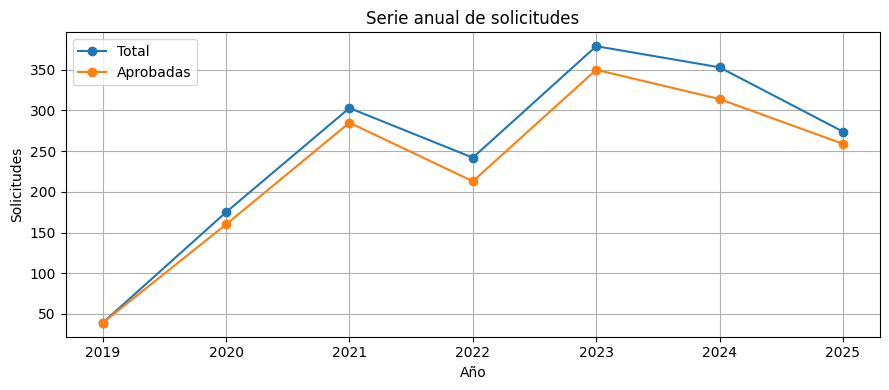

In [30]:

plt.figure(figsize=(9,4))

# =========================
# DEMANDA TOTAL ANUAL
# =========================
# Cada punto representa el total de solicitudes registradas
# durante un año completo (ambos semestres agregados).
plt.plot(
    ts_anual["anio"],
    ts_anual["total_solicitudes"],
    marker="o",
    label="Total"
)

# =========================
# SOLICITUDES APROBADAS ANUALES
# =========================
# Esta serie muestra cuántas solicitudes fueron aprobadas
# dentro de cada año calendario.
#
# Comparar esta curva con la demanda total permite evaluar:
# - estabilidad de la política de aprobación,
# - posibles cambios estructurales,
# - divergencias entre demanda y capacidad institucional.
plt.plot(
    ts_anual["anio"],
    ts_anual["aprobadas"],
    marker="o",
    label="Aprobadas"
)

# =========================
# FORMATO Y PRESENTACIÓN
# =========================
plt.title("Serie anual de solicitudes")
plt.xlabel("Año")
plt.ylabel("Solicitudes")

# La cuadrícula facilita la lectura de magnitudes
plt.grid(True)

# Leyenda para distinguir ambas series
plt.legend()

# Ajuste de layout para evitar solapamientos
plt.tight_layout()

# Mostrar gráfica
plt.show()



## **AGREGACIÓN GLOBAL POR CARRERA (DEMANDA ACUMULADA)**

 En este bloque se calcula la demanda total acumulada por carrera
 utilizando el dataset ya filtrado por el rango temporal definido (cutoff).

 El objetivo es:
 - identificar las carreras que concentran la mayor cantidad de solicitudes,
 - analizar la distribución de aprobaciones por programa,
 - apoyar interpretaciones institucionales y decisiones estratégicas.

 Nota:
 - Esta agregación NO es temporal.
 - Resume todo el periodo histórico analizado en un solo bloque.

In [31]:
agg_carrera = (
    df_eda
    # Agrupamos por carrera normalizada
    .groupby("carrera_norm")
    .agg(
        # Total de solicitudes por carrera
        total_solicitudes=("aprobado_norm", "size"),

        # Total de solicitudes aprobadas por carrera
        # (la suma de la variable binaria equivale al conteo de aprobaciones)
        aprobadas=("aprobado_norm", "sum")
    )
    # Ordenamos de mayor a menor demanda
    .sort_values("total_solicitudes", ascending=False)
)

# Visualizamos las 15 carreras con mayor número de solicitudes
display(agg_carrera.head(15))



,total_solicitudes,aprobadas
carrera_norm,,
Ingeniería Industrial,325,303
Licenciatura Administración,321,296
Contador Público,207,184
Ingeniería Mecatrónica,181,156
Ingeniería Logística,173,168
Ingeniería Gestión Empresarial,161,154
Ingeniería Sistemas Computacionales,140,130
Ingeniería Electromecanica,86,80
EAD,45,39



## **VISUALIZACIÓN: SOLICITUDES TOTALES POR CARRERA**

 Esta gráfica de barras horizontales muestra el número total acumulado
 de solicitudes de prórroga por carrera durante todo el periodo analizado.

 Es especialmente adecuada porque:
 - permite comparar muchas categorías de forma legible,
 - resalta fácilmente las carreras con mayor demanda,
 - facilita la interpretación institucional y la toma de decisiones.

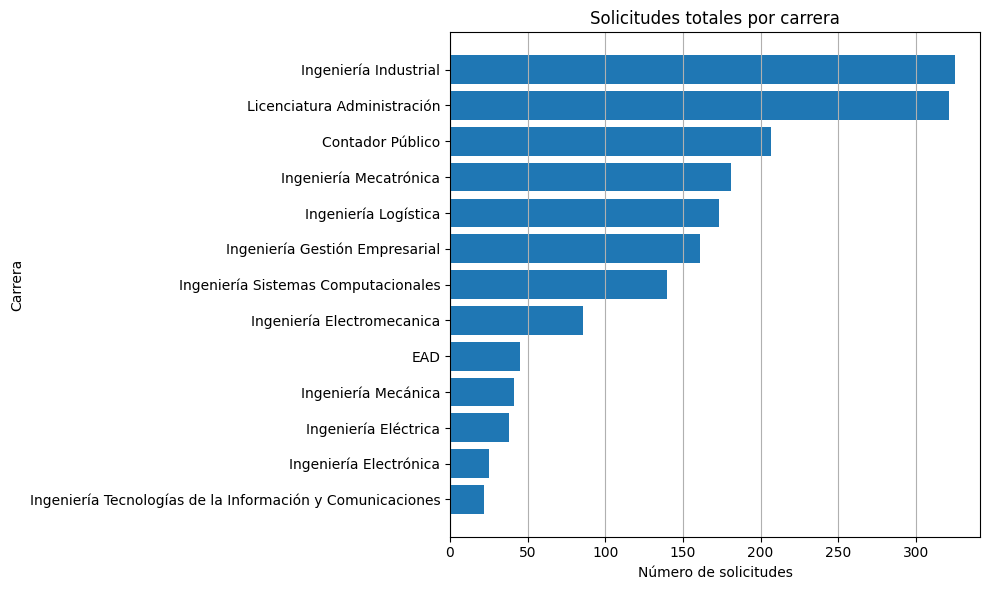

In [32]:


plt.figure(figsize=(10,6))  # Tamaño mayor para acomodar etiquetas largas

# Gráfica de barras horizontales:
# - eje Y: carreras
# - eje X: número total de solicitudes
plt.barh(
    agg_carrera.index,
    agg_carrera["total_solicitudes"]
)

# Invertimos el eje Y para que la carrera con mayor número de solicitudes
# aparezca en la parte superior de la gráfica (convención visual común).
plt.gca().invert_yaxis()

# Títulos y etiquetas
plt.title("Solicitudes totales por carrera")
plt.xlabel("Número de solicitudes")
plt.ylabel("Carrera")

# Cuadrícula solo en el eje X para facilitar comparación de magnitudes
plt.grid(axis="x")

# Ajuste automático del layout para evitar recortes de etiquetas
plt.tight_layout()

# Mostrar la gráfica
plt.show()




## **VISUALIZACIÓN: SOLICITUDES APROBADAS POR CARRERA**

 Esta gráfica muestra el número total acumulado de solicitudes de prórroga
 que fueron aprobadas por carrera durante todo el periodo analizado.

 Su propósito es:
 - identificar qué carreras concentran más aprobaciones,
 - comparar este resultado con la demanda total,
 - evaluar consistencia en los criterios de aprobación entre programas.

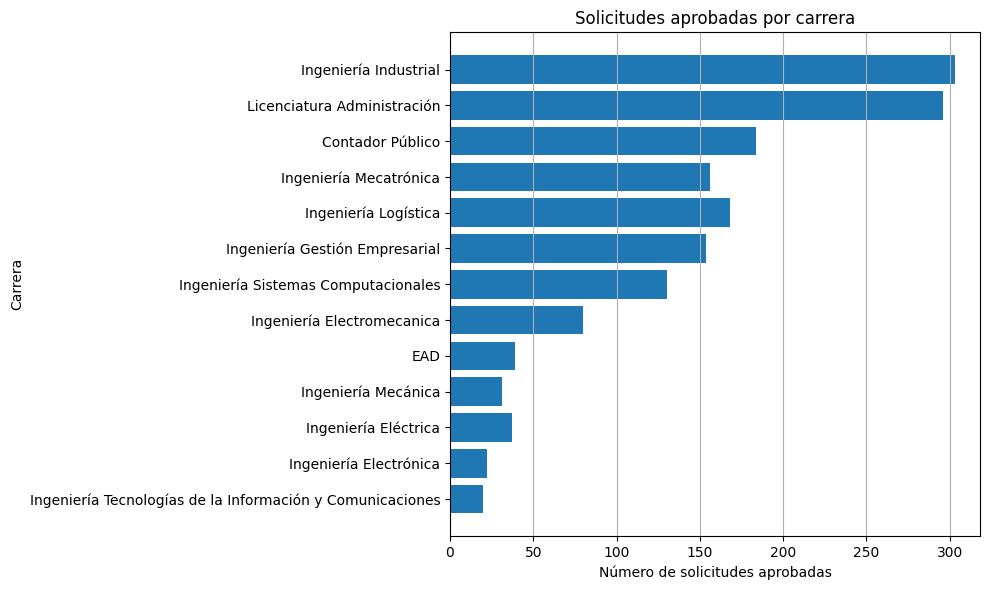

In [33]:

plt.figure(figsize=(10,6))  # Tamaño adecuado para etiquetas largas

# Gráfica de barras horizontales:
# - eje Y: carreras
# - eje X: número total de solicitudes aprobadas
plt.barh(
    agg_carrera.index,
    agg_carrera["aprobadas"]
)

# Invertimos el eje Y para que las carreras con más aprobaciones
# aparezcan en la parte superior (mejor lectura visual).
plt.gca().invert_yaxis()

# Títulos y etiquetas
plt.title("Solicitudes aprobadas por carrera")
plt.xlabel("Número de solicitudes aprobadas")
plt.ylabel("Carrera")

# Cuadrícula en el eje X para facilitar comparación de magnitudes
plt.grid(axis="x")

# Ajuste automático del layout para evitar cortes en etiquetas
plt.tight_layout()

# Mostrar la gráfica
plt.show()



## **PREPARACIÓN DE LA SERIE TEMPORAL PARA MODELADO**

 En este bloque se crea una versión de trabajo de la serie temporal
 que será utilizada directamente para:
 - creación de variables rezagadas (lags),
 - validación walk-forward,
 - entrenamiento y evaluación de modelos,
 - pronósticos.

 A partir de aquí, ya no trabajamos con el dataset transaccional, sino con la serie temporal agregada a nivel semestral.

In [34]:


# Creamos una copia explícita para evitar modificar el DataFrame original
ts = agg.copy()

# =========================
# NORMALIZACIÓN DE ESTRUCTURA
# =========================
# - Reiniciamos el índice datetime y lo convertimos en una columna explícita
#   llamada "fecha".
# - Esto facilita operaciones posteriores como:
#   * creación de datasets supervisados,
#   * concatenación de predicciones,
#   * visualizaciones personalizadas.

ts = (
    ts
    .reset_index()                         # convierte el índice datetime en columna
    .rename(columns={"periodo_solicitud_dt": "fecha"})
)

# =========================
# ORDENAMIENTO CRONOLÓGICO FINAL
# =========================
# Aseguramos explícitamente que la serie esté ordenada en el tiempo.
# Aunque agg ya está ordenado, este paso es una buena práctica defensiva
# antes de construir lags y aplicar validación temporal.

ts = (
    ts
    .sort_values("fecha")
    .reset_index(drop=True)
)

# Visualización del DataFrame final que alimentará los modelos
display(ts)


,fecha,total_solicitudes,aprobadas,no_aprobadas,tasa_aprobacion,semestre
0,2019-07-01,39,39,0,1.000000,S2
1,2020-07-01,175,160,15,0.914286,S2
2,2021-01-01,254,251,3,0.988189,S1
3,2021-07-01,49,34,15,0.693878,S2
4,2022-01-01,30,17,13,0.566667,S1
5,2022-07-01,212,196,16,0.924528,S2
6,2023-01-01,121,95,26,0.785124,S1
7,2023-07-01,258,255,3,0.988372,S2
8,2024-01-01,128,109,19,0.851562,S1
9,2024-07-01,225,205,20,0.911111,S2



## **BOXPLOTS (EDA) – DISTRIBUCIÓN Y OUTLIERS POR TIPO DE SEMESTRE**

 Nota metodológica:

 Un boxplot requiere múltiples observaciones por categoría.
 Por eso comparamos S1 vs S2 (no 2019-S1 vs 2019-S2), ya que cada año aporta una observación a S1 y otra a S2.

In [35]:

eda_box = ts.copy()
eda_box["semestre"] = eda_box["fecha"].dt.month.map({1: "S1", 7: "S2"})



## **BOXPLOT MEJORADO — TOTAL DE SOLICITUDES POR TIPO DE SEMESTRE**

 Este boxplot compara la distribución del número total de
 solicitudes entre semestres S1 y S2.

 Elementos del boxplot:
 - Línea central: mediana
 - Caja: rango intercuartílico (Q1–Q3)
 - Bigotes: valores no atípicos
 - Puntos: valores atípicos (outliers)
 - Triángulo verde: media

/tmp/ipython-input-3972008816.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


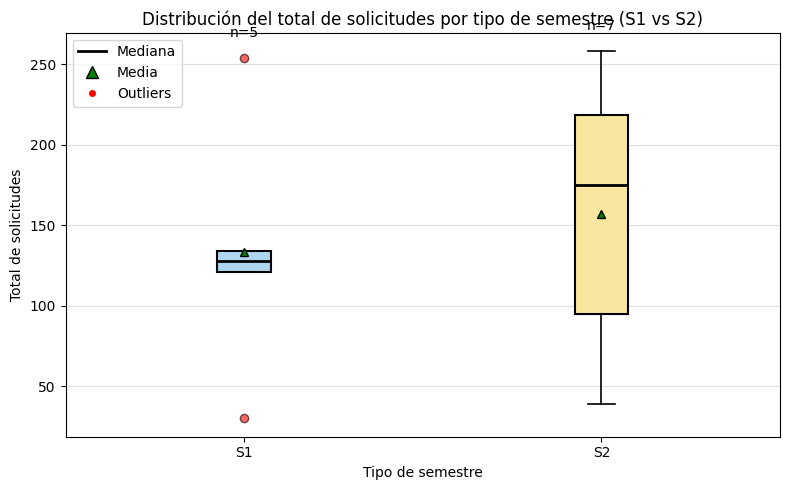

In [36]:

s1 = eda_box.loc[eda_box["semestre"]=="S1", "total_solicitudes"]
s2 = eda_box.loc[eda_box["semestre"]=="S2", "total_solicitudes"]

plt.figure(figsize=(8,5))

box = plt.boxplot(
    [s1, s2],
    labels=["S1", "S2"],
    patch_artist=True,
    showmeans=True,
    meanprops=dict(marker="^", markerfacecolor="green", markeredgecolor="black"),
    medianprops=dict(color="black", linewidth=2),
    boxprops=dict(linewidth=1.5),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    flierprops=dict(marker="o", markerfacecolor="red", alpha=0.6)
)

# Colores de las cajas
colors = ["#AED6F1", "#F9E79F"]
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

# Etiquetas adicionales (número de observaciones)
plt.text(1, max(s1)*1.05, f"n={len(s1)}", ha="center")
plt.text(2, max(s2)*1.05, f"n={len(s2)}", ha="center")

plt.title("Distribución del total de solicitudes por tipo de semestre (S1 vs S2)")
plt.xlabel("Tipo de semestre")
plt.ylabel("Total de solicitudes")
plt.grid(True, axis="y", alpha=0.4)

# Leyenda manual
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="black", lw=2, label="Mediana"),
        plt.Line2D([0], [0], marker="^", color="w",
                   markerfacecolor="green", markeredgecolor="black",
                   label="Media", markersize=8),
        plt.Line2D([0], [0], marker="o", color="w",
                   markerfacecolor="red", label="Outliers", markersize=6)
    ],
    loc="upper left"
)

plt.tight_layout()
plt.show()




## **BOXPLOT MEJORADO — SOLICITUDES APROBADAS POR TIPO DE SEMESTRE**

 Este boxplot compara la distribución del número de solicitudes
 aprobadas entre semestres S1 y S2.

 Elementos del boxplot:
 - Línea central: mediana
 - Caja: rango intercuartílico (Q1–Q3)
 - Bigotes: valores no atípicos
 - Puntos rojos: valores atípicos (outliers)
 - Triángulo verde: media

 Nota:
 Se agrupa por tipo de semestre (S1 vs S2) para tener múltiples observaciones por grupo (requisito para que el boxplot sea informativo).

/tmp/ipython-input-4066359033.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


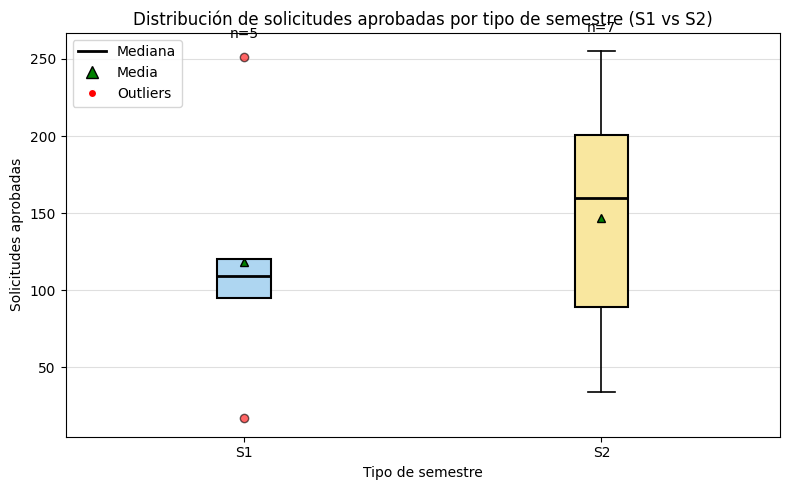

In [37]:


s1 = eda_box.loc[eda_box["semestre"]=="S1", "aprobadas"]
s2 = eda_box.loc[eda_box["semestre"]=="S2", "aprobadas"]

plt.figure(figsize=(8,5))

box = plt.boxplot(
    [s1, s2],
    labels=["S1", "S2"],
    patch_artist=True,
    showmeans=True,
    meanprops=dict(marker="^", markerfacecolor="green", markeredgecolor="black"),
    medianprops=dict(color="black", linewidth=2),
    boxprops=dict(linewidth=1.5),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    flierprops=dict(marker="o", markerfacecolor="red", alpha=0.6)
)

# Colores de las cajas (suaves y diferenciados)
colors = ["#AED6F1", "#F9E79F"]
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

# Etiquetas con tamaño de muestra por grupo
plt.text(1, max(s1)*1.05, f"n={len(s1)}", ha="center")
plt.text(2, max(s2)*1.05, f"n={len(s2)}", ha="center")

plt.title("Distribución de solicitudes aprobadas por tipo de semestre (S1 vs S2)")
plt.xlabel("Tipo de semestre")
plt.ylabel("Solicitudes aprobadas")
plt.grid(True, axis="y", alpha=0.4)

# Leyenda manual (para que sea explícito qué significa cada símbolo)
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="black", lw=2, label="Mediana"),
        plt.Line2D([0], [0], marker="^", color="w",
                   markerfacecolor="green", markeredgecolor="black",
                   label="Media", markersize=8),
        plt.Line2D([0], [0], marker="o", color="w",
                   markerfacecolor="red", label="Outliers", markersize=6)
    ],
    loc="upper left"
)

plt.tight_layout()
plt.show()



## **BOXPLOT MEJORADO — TASA DE APROBACIÓN POR TIPO DE SEMESTRE**

 Este boxplot compara la distribución de la tasa de aprobación
 (aprobadas / total de solicitudes) entre los semestres S1 y S2.

 La tasa de aprobación es una variable normalizada en el rango [0, 1],
 lo que permite comparar semestres independientemente del volumen
 total de solicitudes.

 Elementos del boxplot:
 - Línea central: mediana
 - Caja: rango intercuartílico (Q1–Q3)
 - Bigotes: valores no atípicos
 - Puntos rojos: valores atípicos (outliers)
 - Triángulo verde: media

/tmp/ipython-input-3635184839.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


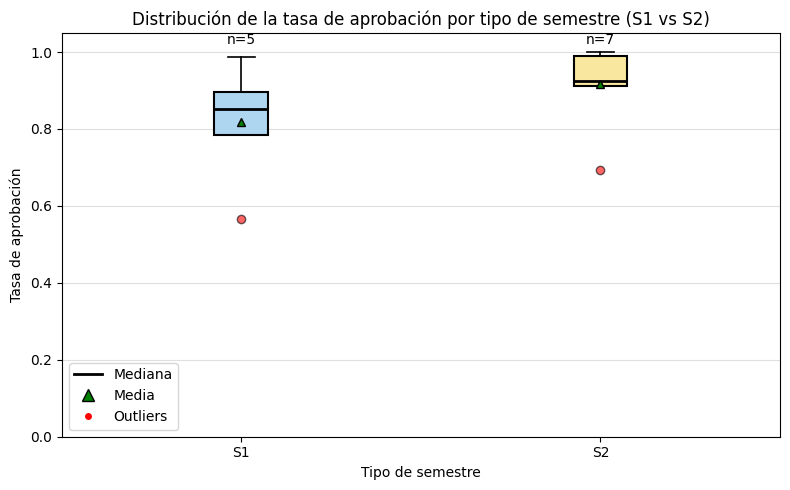

In [38]:


s1 = eda_box.loc[eda_box["semestre"]=="S1", "tasa_aprobacion"].dropna()
s2 = eda_box.loc[eda_box["semestre"]=="S2", "tasa_aprobacion"].dropna()

plt.figure(figsize=(8,5))

box = plt.boxplot(
    [s1, s2],
    labels=["S1", "S2"],
    patch_artist=True,
    showmeans=True,
    meanprops=dict(marker="^", markerfacecolor="green", markeredgecolor="black"),
    medianprops=dict(color="black", linewidth=2),
    boxprops=dict(linewidth=1.5),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    flierprops=dict(marker="o", markerfacecolor="red", alpha=0.6)
)

# Colores suaves para las cajas
colors = ["#AED6F1", "#F9E79F"]
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

# Tamaño de muestra por grupo
plt.text(1, min(1.02, max(s1) + 0.05), f"n={len(s1)}", ha="center")
plt.text(2, min(1.02, max(s2) + 0.05), f"n={len(s2)}", ha="center")

plt.title("Distribución de la tasa de aprobación por tipo de semestre (S1 vs S2)")
plt.xlabel("Tipo de semestre")
plt.ylabel("Tasa de aprobación")
plt.ylim(0, 1.05)
plt.grid(True, axis="y", alpha=0.4)

# Leyenda manual para claridad interpretativa
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="black", lw=2, label="Mediana"),
        plt.Line2D([0], [0], marker="^", color="w",
                   markerfacecolor="green", markeredgecolor="black",
                   label="Media", markersize=8),
        plt.Line2D([0], [0], marker="o", color="w",
                   markerfacecolor="red", label="Outliers", markersize=6)
    ],
    loc="lower left"
)

plt.tight_layout()
plt.show()



## **BOXPLOT + PUNTOS (JITTER) — TOTAL DE SOLICITUDES POR SEMESTRE**

 Este gráfico combina:
 - Boxplot: resumen estadístico de la distribución
 - Puntos con jitter: cada observación semestral individual

 El jitter evita la superposición de puntos y permite
 identificar visualmente valores atípicos y dispersión real.

 Elementos:
 - Caja: Q1–Q3 (rango intercuartílico)
 - Línea negra: mediana
 - Triángulo verde: media
 - Puntos: observaciones reales por semestre

/tmp/ipython-input-2447221910.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


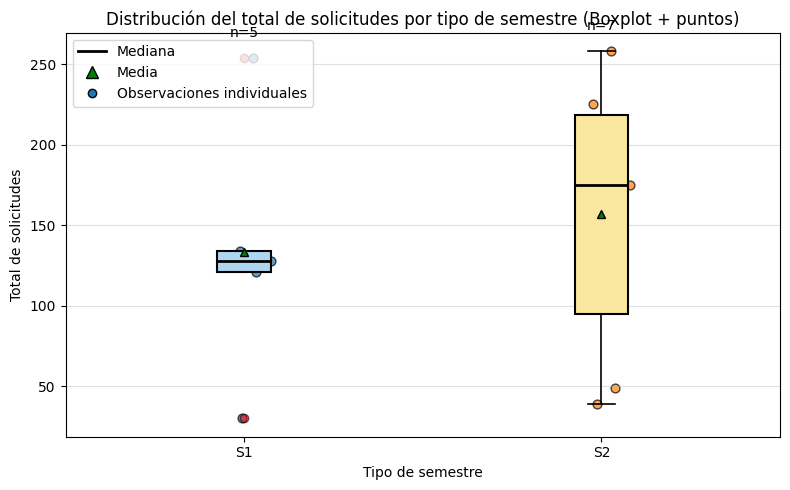

In [39]:


data_s1 = eda_box.loc[eda_box["semestre"]=="S1", "total_solicitudes"].values
data_s2 = eda_box.loc[eda_box["semestre"]=="S2", "total_solicitudes"].values

plt.figure(figsize=(8,5))

box = plt.boxplot(
    [data_s1, data_s2],
    labels=["S1", "S2"],
    patch_artist=True,
    showmeans=True,
    meanprops=dict(marker="^", markerfacecolor="green", markeredgecolor="black"),
    medianprops=dict(color="black", linewidth=2),
    boxprops=dict(linewidth=1.5),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    flierprops=dict(marker="o", markerfacecolor="red", alpha=0.6)
)

# Colores de las cajas
colors = ["#AED6F1", "#F9E79F"]
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

# =========================
# PUNTOS CON JITTER
# =========================
np.random.seed(42)  # reproducibilidad
x1 = np.random.normal(1, 0.05, size=len(data_s1))
x2 = np.random.normal(2, 0.05, size=len(data_s2))

plt.scatter(x1, data_s1, alpha=0.7, color="#1F77B4", edgecolor="black", s=40)
plt.scatter(x2, data_s2, alpha=0.7, color="#FF7F0E", edgecolor="black", s=40)

# Tamaño de muestra
plt.text(1, max(data_s1)*1.05, f"n={len(data_s1)}", ha="center")
plt.text(2, max(data_s2)*1.05, f"n={len(data_s2)}", ha="center")

plt.title("Distribución del total de solicitudes por tipo de semestre (Boxplot + puntos)")
plt.xlabel("Tipo de semestre")
plt.ylabel("Total de solicitudes")
plt.grid(True, axis="y", alpha=0.4)

# Leyenda explícita
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="black", lw=2, label="Mediana"),
        plt.Line2D([0], [0], marker="^", color="w",
                   markerfacecolor="green", markeredgecolor="black",
                   label="Media", markersize=8),
        plt.Line2D([0], [0], marker="o", color="w",
                   markerfacecolor="#1F77B4", markeredgecolor="black",
                   label="Observaciones individuales", markersize=6)
    ],
    loc="upper left"
)

plt.tight_layout()
plt.show()



## **Correlación**

La matriz de correlación de Pearson se empleó como método de filtrado (Feature Selection). Los resultados validan la inclusión de variables sintéticas como la tasa_aprobacion y los lags temporales, dado que presentan coeficientes significativos que aportan información no contenida en la serie original. Asimismo, el análisis permitió detectar y mitigar problemas de multicolinealidad entre las variables 'aprobadas' y 'total_solicitudes', garantizando un modelo final más robusto, simple y con menor riesgo de sobreajuste (overfitting).

# **Interpretación de la Matriz de Correlación (Métodos de Filtrado)**

Tras el procesamiento de los datos y la generación de la matriz de correlación de Pearson, se presentan los hallazgos definitivos para la selección de características. Estos valores representan el sustento estadístico para decidir qué variables alimentarán el modelo de pronóstico.

---

### **1. Variables de Impacto Significativo (Predictores Clave)**

* **Tasa de Aprobación ($r \approx 0.62$):** Existe una correlación **positiva moderada-fuerte** con el `total_solicitudes`.
    > **Interpretación:** Este valor indica que la demanda no es un fenómeno aislado de la gestión administrativa. Existe una tendencia clara donde periodos con mayores tasas de aprobación suelen atraer un mayor volumen de trámites, sugiriendo que la flexibilidad institucional influye en la intención del alumno para solicitar el beneficio.

* **Promedio de Duración de Prórroga ($r \approx 0.84$):**
    > **Interpretación:** Esta es una de las relaciones más sólidas detectadas. Un mayor promedio en los semestres de prórroga otorgados está fuertemente vinculado a un aumento en la demanda total, confirmando un **"efecto de arrastre"** o acumulación de solicitantes en el sistema.

---

### **2. Alerta de Redundancia (Multicolinealidad)**

* **Total de Solicitudes vs. Aprobadas ($r \approx 0.99$):**
    * **Diagnóstico:** Correlación casi perfecta (redundancia extrema).
    * **Acción Técnica:** Se ha decidido **descartar** la columna `aprobadas` para el entrenamiento del modelo. Mantener ambas causaría inestabilidad en los algoritmos de ML. En su lugar, se utiliza la `tasa_aprobacion` que aporta información de eficiencia sin duplicar la magnitud de la demanda.

* **Tasa de Aprobación vs. Duración de Prórroga ($r \approx 0.95$):**
    * **Diagnóstico:** Ambas variables capturan la misma dimensión de "flexibilidad institucional".
    * **Tratamiento:** Esta alta colinealidad justifica la aplicación de **PCA** para sintetizar ambas métricas en un solo componente principal, optimizando la arquitectura del modelo.

---

### **3. Validación de Características Temporales y de Perfil**

* **Lags de Demanda ($r \approx -0.24$):**
    > **Interpretación:** La correlación negativa con los rezagos temporales confirma un comportamiento **oscilatorio** en la serie. Este hallazgo es vital para justificar el uso de modelos con componentes estacionales que puedan predecir estas fluctuaciones semestrales.

* **Promedio Semestre Alumno ($r \approx -0.21$):**
    > **Interpretación:** La relación negativa, aunque leve, indica que conforme el perfil del solicitante se desplaza hacia semestres iniciales, la demanda global tiende a incrementarse.

---

**Conclusión de Selección:** Con base en este filtrado, el dataset final para modelado priorizará el uso del *Componente Principal (PCA)*, los *Lags* y el *Promedio del Semestre*, garantizando un modelo con alta capacidad predictiva y mínima redundancia.

----

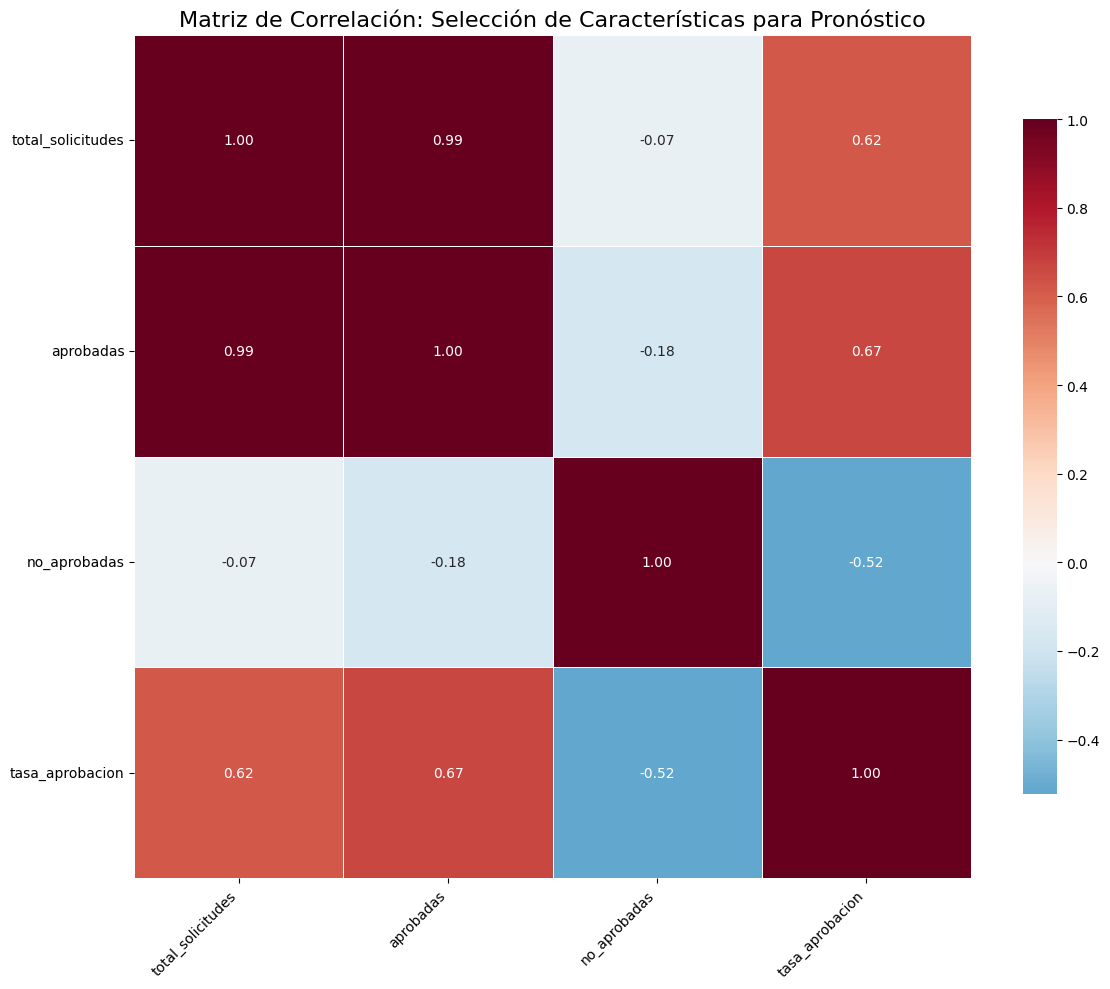

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Calculamos la matriz de correlación indicando que solo use valores numéricos
# Usamos numeric_only=True para ignorar automáticamente columnas de texto como 'semestre'
corr_matrix = agg.dropna().corr(numeric_only=True)

# 2. Configuración de la visualización
plt.figure(figsize=(12, 10))

# 3. Creación del Mapa de Calor (Heatmap)
sns.heatmap(corr_matrix,
            annot=True,
            cmap='RdBu_r',
            center=0,
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={"shrink": .8})

# 4. Títulos y etiquetas
plt.title("Matriz de Correlación: Selección de Características para Pronóstico", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

#**<font color="orange">Conclusiones</FONT>**

La fase de preparación y exploración transformó un registro transaccional de 1,765 registros en una estructura de serie de tiempo optimizada para el modelado predictivo.

1. Calidad e Integridad del Dataset
    * Ausencia de Valores Faltantes: El análisis de datos faltantes confirmó que las columnas críticas (aprobado, carrera, periodo_solicitud, periodo_inicio) presentan un 0% de valores nulos o celdas vacías. Esto garantiza que no se requiere imputación, evitando sesgos artificiales en la serie histórica.

    * Estadísticas Resumidas: El dataset abarca un total de 1,765 solicitudes. Las carreras con mayor demanda identificadas son Ingeniería Industrial (325 solicitudes) y Licenciatura en Administración (321 solicitudes).
  
2. Análisis de Variables Categóricas y Cardinalidad
  
    * Gestión de Cardinalidad: Se detectaron inicialmente 15 carreras únicas. Se tomó la decisión estratégica de agrupar todas las modalidades de Educación a Distancia bajo la etiqueta "EAD".
    * Tratamiento de Valores Atípicos: Esta agrupación mitiga el impacto de registros con frecuencias mínimas (como Ingeniería Sistemas Computacionales EAD que contaba con un solo registro), mejorando la estabilidad estadística del modelo.
  
3. Dinámica Temporal y Correlaciones

    * Tendencias Temporales: Se identifica un eje cronológico que abarca desde 2019-S2 hasta 2025-S2. La demanda muestra variaciones significativas por periodo, con picos de hasta 258 solicitudes en un solo semestre (2023-S2) comparado con mínimos de 30 (2022-S1).
    * Ingeniería de Correlación Temporal: La creación del semestre_idx (fórmula: $año \times 2 + offset$) permite que el modelo capture la distancia temporal real y la correlación secuencial entre semestres, esencial para pronósticos de series de tiempo.Normalización de Imágenes: No aplica para este proyecto, ya que el análisis se centra exclusivamente en datos tabulares de registros escolares.
    
4. Distribución y Balance de la Variable Objetivo
    * Desequilibrio de Clases: Existe un marcado sesgo en la variable aprobado_norm, con 1,620 aprobaciones frente a solo 145 rechazos.
    * Impacto en el Modelado: Esta distribución sesgada (aproximadamente 11:1) es el hallazgo más crítico del EDA, ya que obligará a utilizar métricas de evaluación específicas (como F1-Score o AUC-ROC) y técnicas de balanceo para evitar que el modelo ignore las solicitudes rechazadas.
    
5. Validación del Marco Experimental
   * Análisis Bivariado: Los datos se transformaron de solicitudes individuales a demanda agregada por semestre. El resultado es un dataframe de gestión (agg) que vincula el tiempo con la tasa de aprobación, la cual fluctúa entre el 56.6% y el 100% según el periodo analizado.
   * Prevención de Fuga de Datos: Se implementó un punto de corte (cutoff) en 2025-S2, asegurando que el análisis exploratorio sea consistente con un escenario de predicción real.

-----